In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install librosa

In [0]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('/content/drive/My Drive/Ravdess/Actor1/Actor_01/03-02-01-01-01-01-01.wav')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


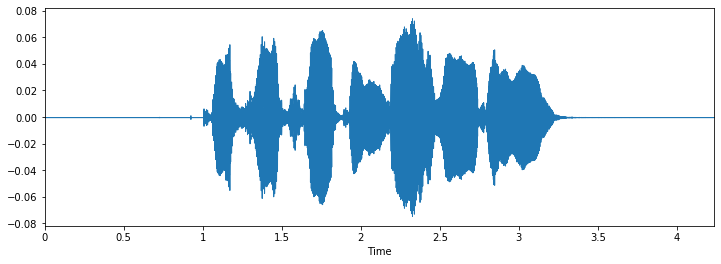

In [0]:
% pylab inline
import os
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

# Load all files

Extracting Mel-frequency cepstral coefficients (MFCCs)

In [0]:
import time

path = '/content/drive/My Drive/Ravdess/Actor1'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 473.3380661010742 seconds ---


In [0]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [0]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((1012, 40), (1012,))

# Decision Tree Classifier

Creating a basic model to test on dataset.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
dtree = DecisionTreeClassifier()

In [0]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
predictions = dtree.predict(X_test)

In [0]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63        25
           1       0.87      0.66      0.75        73
           2       0.54      0.60      0.57        55
           3       0.59      0.60      0.59        67
           4       0.50      0.66      0.57        47
           5       0.63      0.58      0.60        67

    accuracy                           0.62       334
   macro avg       0.62      0.62      0.62       334
weighted avg       0.64      0.62      0.62       334



# Neural network

In [0]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [0]:
x_traincnn.shape, x_testcnn.shape

((678, 40, 1), (334, 40, 1))

In [0]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



With *model.summary* we can see a recap of what we have build:

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)           

Now we can compile and fit our model:

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 678 samples, validate on 334 samples
Epoch 1/1000





678/678 [==============================] - 1s 2ms/step - loss: 9.5822 - acc: 0.1519 - val_loss: 7.9700 - val_acc: 0.1557
Epoch 2/1000
678/678 [==============================] - 0s 532us/step - loss: 8.6577 - acc: 0.2035 - val_loss: 8.5252 - val_acc: 0.0749
Epoch 3/1000
678/678 [==============================] - 0s 494us/step - loss: 8.8713 - acc: 0.1770 - val_loss: 8.1240 - val_acc: 0.1407
Epoch 4/1000
678/678 [==============================] - 0s 511us/step - loss: 7.8103 - acc: 0.1681 - val_loss: 5.4060 - val_acc: 0.1407
Epoch 5/1000
678/678 [==============================] - 0s 527us/step - loss: 6.9173 - acc: 0.1991 - val_loss: 4.9154 - val_acc: 0.1916
Epoch 6/1000
678/678 [==============================] - 0s 533us/step - loss: 6.8034 - acc: 0.1814 - val_loss: 5.3172 - val_acc: 0.2186
Epoch 7/1000
678/678 [================

Let's plot the loss:

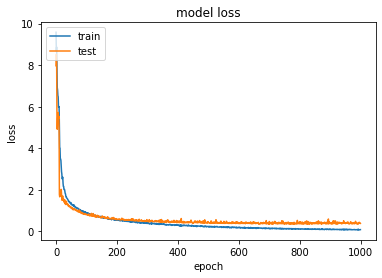

In [0]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



And now let's plot the accuracy:

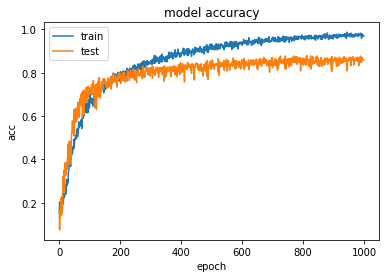

In [0]:
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Let's now create a classification report to review the f1-score of the model per class.
To do so, we have to:
- Create a variable predictions that will contain the model.predict_classes outcome
- Convert our y_test (array of strings with our classes) to an array of int called new_Ytest, otherwise it will not be comparable to the predictions by the classification report.

In [0]:
predictions = model.predict_classes(x_testcnn)

In [0]:
predictions

array([1, 2, 2, 2, 2, 5, 0, 3, 4, 3, 5, 5, 0, 1, 3, 5, 5, 3, 2, 1, 4, 1,
       4, 2, 5, 5, 5, 1, 5, 4, 3, 5, 4, 2, 2, 3, 0, 5, 4, 3, 1, 2, 4, 1,
       2, 0, 4, 1, 5, 1, 0, 1, 1, 2, 2, 4, 0, 0, 5, 3, 5, 2, 5, 2, 3, 0,
       1, 1, 3, 1, 1, 1, 1, 5, 1, 4, 1, 0, 1, 4, 3, 2, 2, 2, 2, 1, 1, 5,
       1, 4, 3, 3, 3, 2, 1, 4, 2, 3, 3, 1, 3, 3, 3, 5, 5, 2, 1, 0, 5, 3,
       5, 3, 5, 1, 0, 5, 1, 1, 5, 4, 2, 5, 1, 1, 3, 2, 2, 2, 1, 2, 2, 5,
       5, 2, 2, 3, 1, 3, 2, 3, 3, 5, 5, 4, 3, 3, 2, 5, 2, 4, 4, 1, 3, 1,
       3, 4, 1, 4, 3, 1, 3, 5, 3, 2, 5, 1, 5, 4, 2, 2, 4, 2, 5, 2, 2, 3,
       1, 2, 5, 4, 2, 4, 4, 5, 5, 4, 2, 1, 3, 2, 5, 5, 3, 3, 2, 0, 4, 0,
       5, 1, 2, 4, 2, 4, 1, 4, 4, 1, 5, 5, 2, 4, 1, 1, 5, 3, 2, 2, 2, 4,
       3, 1, 0, 5, 2, 2, 5, 4, 0, 1, 1, 5, 3, 1, 2, 3, 2, 2, 3, 2, 4, 5,
       3, 4, 0, 5, 1, 2, 4, 2, 5, 3, 4, 5, 5, 4, 1, 1, 3, 3, 2, 4, 5, 0,
       5, 5, 0, 5, 4, 1, 4, 1, 4, 5, 4, 1, 3, 1, 5, 5, 5, 1, 4, 4, 2, 5,
       5, 2, 1, 0, 2, 4, 1, 4, 0, 0, 1, 3, 1, 1, 5,

In [0]:
y_test

array([1, 2, 2, 2, 2, 5, 0, 3, 4, 3, 5, 3, 0, 1, 3, 5, 3, 3, 1, 1, 4, 1,
       4, 2, 5, 5, 5, 1, 5, 4, 3, 5, 4, 1, 2, 3, 0, 5, 4, 3, 1, 2, 4, 5,
       2, 0, 5, 1, 5, 5, 0, 1, 1, 2, 2, 4, 0, 0, 3, 3, 5, 3, 5, 1, 3, 0,
       1, 1, 3, 1, 1, 1, 1, 5, 1, 4, 1, 0, 1, 4, 3, 2, 2, 2, 2, 1, 1, 5,
       1, 4, 3, 3, 5, 2, 1, 4, 2, 3, 3, 1, 3, 3, 3, 5, 5, 2, 1, 0, 5, 3,
       5, 3, 5, 1, 0, 5, 1, 1, 5, 4, 2, 5, 1, 1, 3, 2, 1, 2, 1, 2, 2, 5,
       5, 2, 2, 3, 1, 4, 2, 3, 3, 5, 5, 0, 3, 3, 1, 5, 2, 4, 4, 1, 3, 1,
       3, 4, 2, 4, 3, 1, 3, 5, 3, 2, 3, 1, 5, 3, 1, 2, 4, 1, 3, 2, 2, 3,
       1, 5, 5, 4, 2, 4, 3, 5, 3, 4, 2, 1, 5, 2, 5, 3, 3, 3, 1, 3, 4, 0,
       5, 1, 2, 3, 2, 4, 2, 4, 4, 1, 5, 5, 2, 4, 2, 1, 3, 3, 2, 2, 2, 4,
       3, 1, 0, 5, 1, 2, 5, 5, 0, 1, 1, 5, 3, 1, 2, 3, 2, 2, 3, 2, 4, 5,
       3, 5, 0, 5, 1, 2, 5, 2, 5, 3, 5, 5, 5, 4, 1, 1, 3, 5, 1, 4, 5, 0,
       5, 5, 0, 5, 4, 1, 4, 1, 4, 5, 4, 1, 3, 1, 3, 5, 5, 1, 4, 4, 2, 5,
       3, 2, 1, 0, 2, 4, 1, 4, 0, 5, 1, 3, 2, 1, 5,

In [0]:
new_Ytest = y_test.astype(int)

In [0]:
new_Ytest

array([1, 2, 2, 2, 2, 5, 0, 3, 4, 3, 5, 3, 0, 1, 3, 5, 3, 3, 1, 1, 4, 1,
       4, 2, 5, 5, 5, 1, 5, 4, 3, 5, 4, 1, 2, 3, 0, 5, 4, 3, 1, 2, 4, 5,
       2, 0, 5, 1, 5, 5, 0, 1, 1, 2, 2, 4, 0, 0, 3, 3, 5, 3, 5, 1, 3, 0,
       1, 1, 3, 1, 1, 1, 1, 5, 1, 4, 1, 0, 1, 4, 3, 2, 2, 2, 2, 1, 1, 5,
       1, 4, 3, 3, 5, 2, 1, 4, 2, 3, 3, 1, 3, 3, 3, 5, 5, 2, 1, 0, 5, 3,
       5, 3, 5, 1, 0, 5, 1, 1, 5, 4, 2, 5, 1, 1, 3, 2, 1, 2, 1, 2, 2, 5,
       5, 2, 2, 3, 1, 4, 2, 3, 3, 5, 5, 0, 3, 3, 1, 5, 2, 4, 4, 1, 3, 1,
       3, 4, 2, 4, 3, 1, 3, 5, 3, 2, 3, 1, 5, 3, 1, 2, 4, 1, 3, 2, 2, 3,
       1, 5, 5, 4, 2, 4, 3, 5, 3, 4, 2, 1, 5, 2, 5, 3, 3, 3, 1, 3, 4, 0,
       5, 1, 2, 3, 2, 4, 2, 4, 4, 1, 5, 5, 2, 4, 2, 1, 3, 3, 2, 2, 2, 4,
       3, 1, 0, 5, 1, 2, 5, 5, 0, 1, 1, 5, 3, 1, 2, 3, 2, 2, 3, 2, 4, 5,
       3, 5, 0, 5, 1, 2, 5, 2, 5, 3, 5, 5, 5, 4, 1, 1, 3, 5, 1, 4, 5, 0,
       5, 5, 0, 5, 4, 1, 4, 1, 4, 5, 4, 1, 3, 1, 3, 5, 5, 1, 4, 4, 2, 5,
       3, 2, 1, 0, 2, 4, 1, 4, 0, 5, 1, 3, 2, 1, 5,

Okay, now we can display the classification report:

In [0]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       0.90      0.86      0.88        73
           2       0.81      0.93      0.86        55
           3       0.92      0.73      0.82        67
           4       0.83      0.96      0.89        47
           5       0.81      0.82      0.81        67

    accuracy                           0.86       334
   macro avg       0.87      0.88      0.87       334
weighted avg       0.86      0.86      0.86       334



And now, the confusion matrix: it will show us the misclassified samples

In [0]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[24  0  0  0  1  0]
 [ 0 63 10  0  0  0]
 [ 0  4 51  0  0  0]
 [ 1  1  1 49  3 12]
 [ 0  0  0  1 45  1]
 [ 1  2  1  3  5 55]]


# Saving the model

In [0]:
model_name = 'SER.h5'
save_dir = '/content/drive/My Drive/Ravdess/Ravdess_model'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/Ravdess/Ravdess_model/SER.h5 


### Loading saved model

In [0]:
loaded_model = keras.models.load_model('/content/drive/My Drive/Ravdess/Ravdess_model/SER.h5')
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)           

In [0]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

334/334 [==============================] - 0s 314us/step
Restored model, accuracy: 85.93%
